In [ ]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

ERROR: torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


GoogleDrive와 Colab 연동

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Data 확인

In [ ]:
import os
from glob import glob

data_dir = os.listdir('/content/gdrive/Shareddrives/zeogi_gogi/dataset/')

In [ ]:
data_dir

['fear', 'happy', 'sad', 'neutral', 'disgust', 'surprise', 'angry']

In [ ]:
for i in data_dir:
  data_f = glob('/content/gdrive/Shareddrives/zeogi_gogi/dataset/' + i + '/*')
  print(i, len(data_f))

fear 4000
happy 4206
sad 4331
neutral 5104
disgust 4000
surprise 4000
angry 6568


In [ ]:
from glob import glob
DATA_LIST = glob('/content/gdrive/Shareddrives/zeogi_gogi/dataset/*/*.jpg')

In [ ]:
len(DATA_LIST)

32209

In [ ]:
from sklearn.model_selection import train_test_split

train_img_list, val_img_list = train_test_split(DATA_LIST, test_size = 0.1, random_state=2000)
print(len(train_img_list), len(val_img_list))

28988 3221


In [ ]:
val_img_list[:5]

['/content/gdrive/Shareddrives/zeogi_gogi/dataset/angry/angry_3805.jpg',
 '/content/gdrive/Shareddrives/zeogi_gogi/dataset/angry/angry_0808.jpg',
 '/content/gdrive/Shareddrives/zeogi_gogi/dataset/fear/fear_1189.jpg',
 '/content/gdrive/Shareddrives/zeogi_gogi/dataset/happy/happy_1062.jpg',
 '/content/gdrive/Shareddrives/zeogi_gogi/dataset/disgust/disgust_2562.jpg']

In [ ]:
for i in val_img_list[:5]:
  print(i.split('/')[-2])

angry
angry
fear
happy
disgust


DataLoader

In [ ]:
import torch
#from torch.utils.data import Dataset, DataLoader, ConcatDataset, Sampler, RandomSampler, BatchSampler
from torch.utils.data import *
from skimage import io, transform
from torchvision import transforms
import cv2


classes = ('fear', 'happy', 'sad', 'neutral', 'disgust', 'surprise', 'angry')


class MyDataSet(Dataset):

  #data_path_list - 이미지 path 전체 리스트
  #label - 이미지 ground truth
  def __init__(self, data_path_list, classes, transform=None):
    self.path_list = data_path_list
    self.label = MyDataSet.get_label(data_path_list)
    self.transform = transform
    self.classes = classes

  def get_label(data_path_list):
    label_list = []
    for path in data_path_list:
      # 뒤에서 두번째가 class다.
      label_list.append(path.split('/')[-2])   
    return label_list

  def __len__(self):
    return len(self.path_list)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = io.imread(self.path_list[idx], as_gray=True)     # 이미지가 grayscale과 컬러가 섞여있어 gray로 통일
    if self.transform is not None:
      image = self.transform(image)
      return image, self.classes.index(self.label[idx])

In [ ]:
from sklearn.model_selection import train_test_split
from glob import glob
import os

d_path = '/content/gdrive/Shareddrives/zeogi_gogi/dataset/'
f_dir = os.listdir(d_path)

TRAIN_LIST = []
VAL_LIST = []

for i in f_dir:
  DATA_LIST = glob(d_path + str(i) + '/*.jpg')
  train_img_list, val_img_list = train_test_split(DATA_LIST[:4000], test_size = 0.1, random_state=2002)
  print(len(train_img_list), len(val_img_list))
  for j in train_img_list:
    TRAIN_LIST.append(j)
  for k in val_img_list:
    VAL_LIST.append(k)

print(len(TRAIN_LIST), len(VAL_LIST))

3600 400
3600 400
3600 400
3600 400
3600 400
3600 400
3600 400
25200 2800


In [ ]:
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])   # 흑백이미지 transforms.Normalize((0.5,), (0.5,))
                                              # 컬러이미지 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((200,200))])


#own dataset
trainloader = torch.utils.data.DataLoader(MyDataSet(TRAIN_LIST, classes,transform=transform),batch_size=4,shuffle = True,drop_last=True)
testloader = torch.utils.data.DataLoader(MyDataSet(VAL_LIST, classes,transform=transform),batch_size=4,shuffle = False,drop_last=True)

한꺼번에 묶어둔것

In [ ]:
import torch
#from torch.utils.data import Dataset, DataLoader, ConcatDataset, Sampler, RandomSampler, BatchSampler
from torch.utils.data import *
from skimage import io, transform
from torchvision import transforms
import cv2
from PIL import Image


classes = ('fear', 'happy', 'sad', 'neutral', 'disgust', 'surprise', 'angry')


class MyDataSet(Dataset):

  #data_path_list - 이미지 path 전체 리스트
  #label - 이미지 ground truth

  # 데이터셋의 전처리를 해주는 부분
  def __init__(self, data_path_list, classes, transform=None):
    self.path_list = data_path_list
    self.label = self.get_label(data_path_list)
    self.transform = transform
    self.classes = classes

  def get_label(self, data_path_list):
    label_list = []
    for path in data_path_list:
      # 뒤에서 두번째가 class다.
      label_list.append(path.split('/')[-2])   
    return label_list

  # 데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분. 데이터의 크기 리턴
  def __len__(self):
    return len(self.path_list)

  # 데이터셋에서 특정 1개의 샘플을 가져오는 함수. dataset[i]를 했을 때 i번째 샘플을 가져오도록 하는 인덱싱을 위한 함수
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = io.imread(self.path_list[idx], as_gray=True)     # 이미지가 grayscale과 컬러가 섞여있어 gray로 통일
    if self.transform is not None:
      image = Image.fromarray(image)
      image = self.transform(image)
      #image = torch.from_numpy(image).float()
      return image, self.classes.index(self.label[idx])


from sklearn.model_selection import train_test_split
from glob import glob
import os

d_path = '/content/gdrive/Shareddrives/zeogi_gogi/dataset/'
f_dir = os.listdir(d_path)

TRAIN_LIST = []
VAL_LIST = []

for i in f_dir:
  DATA_LIST = glob(d_path + str(i) + '/*.jpg')
  train_img_list, val_img_list = train_test_split(DATA_LIST[:4000], test_size = 0.1, random_state=2002)
  print(len(train_img_list), len(val_img_list))
  for j in train_img_list:
    TRAIN_LIST.append(j)
  for k in val_img_list:
    VAL_LIST.append(k)

#print(len(TRAIN_LIST), len(VAL_LIST))

'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])   # 흑백이미지 transforms.Normalize((0.5,), (0.5,))
                                              # 컬러이미지 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
'''
transform = transforms.Compose(
    [transforms.Resize((224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])


#own dataset
trainloader = torch.utils.data.DataLoader(MyDataSet(TRAIN_LIST, classes,transform=transform),batch_size=64,shuffle = True,drop_last=True)
testloader = torch.utils.data.DataLoader(MyDataSet(VAL_LIST, classes,transform=transform),batch_size=64,shuffle = False,drop_last=True)

3600 400
3600 400
3600 400
3600 400
3600 400
3600 400
3600 400


Show training sample

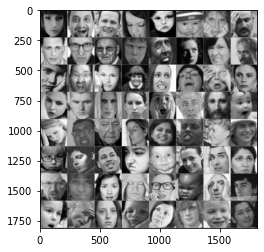

neutral surprise happy angry


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2

# 이미지를 출력해주는 함수
def imshow(img_file):
  npimg = img_file.numpy()
  npimg = npimg / 2 + 0.5   # unnormalize
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# train 이미지 랜덤으로 추출
dataiter = iter(trainloader)
images, labels = dataiter.next()


# 이미지 출력
imshow(torchvision.utils.make_grid(images))


# 라벨 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

VGG16

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch.nn as nn

class VGG16(nn.Module):
  def __init__(self):
    super(VGG16, self).__init__()
    self.conv = nn.Sequential(
        #3 224 128
        nn.Conv2d(1, 64, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),
        #64 112 64
        nn.Conv2d(64, 128, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2),
        #128 56 32
        nn.Conv2d(128, 256, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(256),
        nn.Conv2d(256, 256, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(256),
        nn.Conv2d(256, 256, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2,2),
        #256 28 16
        nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(512),
        nn.Conv2d(512, 512, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(512),
        nn.Conv2d(512, 512, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(2,2),
        #512 14 8
        nn.Conv2d(512, 512, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(512),
        nn.Conv2d(512, 512, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(512),
        nn.Conv2d(512, 512, 3, padding=1), nn.LeakyReLU(0.2),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(2,2),
    )
    #512 7 4
    self.avg_pool = nn.AvgPool2d(7)
    #512 1 1
    self.classifier = nn.Linear(512, 7)  # Fully-Connected layer  출력층으로 10개의 뉴런을 배치하여 7개 차원의 텐서로 변환   # 왜 여기서는 이 레이어를 하나만 했징? 논문은 fc레이어 3개인뎅...
    """
    self.fc1 = nn.Linear(512*2*2,4096)
    self.fc2 = nn.Linear(4096,4096)
    self.fc3 = nn.Linear(4096,10)
    """

  def forward(self, x):
    #x = x.double()
    print(x.size())
    features = self.conv(x)
    print(features.size())
    x = self.avg_pool(features)
    print(x.size())
    x = x.view(features.size(0), -1)    # 배치 차원을 제외하고 나머지는 펼쳐라 
    print(x.size())
    x = self.classifier(x)
    #x = self.softmax(x)
    return x, features


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = VGG16()
model = model.to(device)
print(model)
param = list(model.parameters())
print(len(param))
#for i in param:
#    print(i.shape)
##print(param[0].shape)

VGG16(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.2)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [ ]:
from torchsummary import summary
summary(model, (1, 224, 224))
#summary(model, input_size=(3, 224, 224), device=device.type)

torch.Size([2, 1, 224, 224])
torch.Size([2, 512, 7, 7])
torch.Size([2, 512, 1, 1])
torch.Size([2, 512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
         LeakyReLU-2         [-1, 64, 224, 224]               0
       BatchNorm2d-3         [-1, 64, 224, 224]             128
            Conv2d-4         [-1, 64, 224, 224]          36,928
         LeakyReLU-5         [-1, 64, 224, 224]               0
       BatchNorm2d-6         [-1, 64, 224, 224]             128
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
         LeakyReLU-9        [-1, 128, 112, 112]               0
      BatchNorm2d-10        [-1, 128, 112, 112]             256
           Conv2d-11        [-1, 128, 112, 112]         147,584
        LeakyReLU-12        [-1, 128, 112, 112]               0

In [2]:
import torch
#from torch.utils.data import Dataset, DataLoader, ConcatDataset, Sampler, RandomSampler, BatchSampler
from torch.utils.data import *
from skimage import io, transform
from torchvision import transforms
import cv2
from PIL import Image


classes = ('fear', 'happy', 'sad', 'neutral', 'disgust', 'surprise', 'angry')


class MyDataSet(Dataset):

  #data_path_list - 이미지 path 전체 리스트
  #label - 이미지 ground truth

  # 데이터셋의 전처리를 해주는 부분
  def __init__(self, data_path_list, classes, transform=None):
    self.path_list = data_path_list
    self.label = self.get_label(data_path_list)
    self.transform = transform
    self.classes = classes

  def get_label(self, data_path_list):
    label_list = []
    for path in data_path_list:
      # 뒤에서 두번째가 class다.
      label_list.append(path.split('/')[-2])   
    return label_list

  # 데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분. 데이터의 크기 리턴
  def __len__(self):
    return len(self.path_list)

  # 데이터셋에서 특정 1개의 샘플을 가져오는 함수. dataset[i]를 했을 때 i번째 샘플을 가져오도록 하는 인덱싱을 위한 함수
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = io.imread(self.path_list[idx], as_gray=True)     # 이미지가 grayscale과 컬러가 섞여있어 gray로 통일
    if self.transform is not None:
      image = Image.fromarray(image)
      image = self.transform(image)
      #image = torch.from_numpy(image).float()
      return image, self.classes.index(self.label[idx])


from sklearn.model_selection import train_test_split
from glob import glob
import os

d_path = '/content/drive/Shareddrives/zeogi_gogi/dataset/'
#f_dir = os.listdir(d_path)
f_dir = ['fear', 'happy', 'sad', 'neutral', 'disgust', 'surprise', 'angry']

TRAIN_LIST = []
VAL_LIST = []

for i in f_dir:
  DATA_LIST = glob(d_path + str(i) + '/*.jpg')
  train_img_list, val_img_list = train_test_split(DATA_LIST[:4000], test_size = 0.1, random_state=2002)
  print(len(train_img_list), len(val_img_list))
  for j in train_img_list:
    TRAIN_LIST.append(j)
  for k in val_img_list:
    VAL_LIST.append(k)

#print(len(TRAIN_LIST), len(VAL_LIST))

'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])   # 흑백이미지 transforms.Normalize((0.5,), (0.5,))
                                              # 컬러이미지 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
'''
transform = transforms.Compose(
    [transforms.Resize((224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])


#own dataset
trainloader = torch.utils.data.DataLoader(MyDataSet(TRAIN_LIST, classes,transform=transform),batch_size=64,shuffle = True,drop_last=True)
testloader = torch.utils.data.DataLoader(MyDataSet(VAL_LIST, classes,transform=transform),batch_size=64,shuffle = False,drop_last=True)

3600 400
3600 400
3600 400
3600 400
3600 400
3600 400
3600 400


Model 모듈화

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

In [4]:
class VGG(nn.Module):

  def __init__(self, conv, num_classes=100, init_weights=True):
    super(VGG, self).__init__()  # pytorch에서 class 형태의 모델은 항상 nn.Module을 상속받아야 하며, 
                                 # super(모델명, self).init()을 통해 nn.Module.init()을 실행시키는 코드가 필요

    self.features = conv    # features
    self.avgpool = nn.AvgPool2d(7)
    self.classifier = nn.Linear(512, 7)   # 7은 num_classes
    '''
    self.classifier = nn.Sequential(
      nn.Linear(512*7*7, 4096),
      nn.ReLU(True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(True),
      nn.Dropout(),
      nn.Linear(4096, num_classes),
    )
    '''

    if init_weights:
      self._initialize_weights()
  
  def forward(self, x):  # 모델이 학습 데이터를 입력 받아서 forward prop을 진행시키는 함수
    #features = self.conv(x)
    x = self.features(x).float()
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)   # x = torch.flatten(x, 1) 이걸로도 가능한것인지
    #x = torch.flatten(x, 1)
    x = self.classifier(x)
    #x = self.softmax(x)
    return x


  def _initialize_weights(self):  # 가중치 초기화 
    for m in self.modules():  # self.modules()는 모델 클래스에서 정의된 layer들을 iterable로 차례로 반환
      if isinstance(m, nn.Conv2d):  # isinstance()는 차례로 layer를 입력하여 layer의 형태를 반환(nn.cnv2d, nn,BatchNorm2d 등..)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')    # torch.nn.init.kaiming_normal_ 는  He initialization 을 제공하는 함수 
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)  # torch.nn.init.normal_(tensor, mean=0.0, std=1.0)은 tensor을 mean, std의 normal distribution으로 초기화
        nn.init.constant_(m.bias, 0)  # torch.nn.init.constant_(tensor, val)은 tensor을 val로 초기화


In [5]:
def make_layers(cfg, batch_norm=False):
  layers = []
  in_channels = 1

  for v in cfg:
    if v == 'M':  # max pooling
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    else:
      conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
      else:
        layers += [conv2d, nn.ReLU(inplace=True)]
      in_channels = v
  
  return nn.Sequential(*layers)

In [6]:
cfg = { #8 + 3 =11 == vgg11 
       'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], 
       # 10 + 3 = vgg 13 
       'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], 
       #13 + 3 = vgg 16 
       'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], 
       # 16 +3 =vgg 19 
       'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
       }

In [7]:
conv = make_layers(cfg['D'], batch_norm=True)
# feature = make_layers(cfg['A'], batch_norm=True)

In [8]:
model = VGG(conv, num_classes=7, init_weights=True)

In [9]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
classes = ('fear', 'happy', 'sad', 'neutral', 'disgust', 'surprise', 'angry')
import torch.optim as optim
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


start_time = time.time()
for epoch in range(2):  # loop over the dataset multiple times
    trainLoss = 0.0
    trainSize = 0
    trainCorrect = 0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        model = model.float()
        #outputs,f = model(inputs)
        model = model.cuda()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()

        predicted = outputs.max(1)[1]
        #print(predicted)
        #print(labels)
  
        trainSize += labels.shape[0]
        trainCorrect += predicted.eq(labels.view_as(predicted)).sum().item()
        trainAccuracy = (trainCorrect / trainSize) * 100



        if(loss.item() > 1000):
            print(loss.item())
            for param in model.parameters():
                print(param.data)
        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            torch.save(model, '/content/drive/MyDrive/vgg16_batch{}_loss{}.pt'.format(i+1, trainLoss / 50))
            print('epoch {} batch {} train_loss {}'.format(epoch+1, i+1, trainLoss / 50))
            running_loss = 0.0


    if i%5 == 0:
        with torch.no_grad():
            valLoss = 0
            valSize = 0
            valCorrect = 0

            for j, data in enumerate(testloader):
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                # forward + backward + optimize
                model = model.float()
                #outputs,f = model(inputs)
                model = model.cuda()
                outputs = model(inputs)

                valLoss += criterion(outputs, labels).item()

                predicted = outputs.max(1)[1]
                valSize += labels.shape[0]
                valCorrect += predicted.eq(labels.view_as(predicted)).sum().item()
                valAccuracy = (valCorrect / valSize) * 100
            
            print('validation_loss {}'.format(valLoss))



#torch.save(model, '/content/drive/MyDrive/vgg16.pt')
#torch.save(model.state_dict(), '/content/drive/MyDrive/vgg16.pth')
print(time.time()-start_time)
print('Finished Training')

epoch 1 batch 50 train_loss 1.9037514352798461


In [ ]:
# test
model.eval()

testLoss = 0
testSize = 0
testCorrect = 0

with torch.no_grad():
    for batchIdx, (images, labels) in enumerate(test_set):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        testLoss = criterion(outputs, labels).item()
        predicted = outputs.max(1)[1]

        testSize += labels.shape[0]

        testCorrect += predicted.eq(labels.view_as(predicted)).sum().item()
        testLoss /= len(test_set.dataset)

    accuracy = (testCorrect / testSize) * 100

In [13]:
epoch = 10
lr = 0.0004
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(epoch):
		trainLoss = 0
		trainSize = 0
		trainCorrect = 0

		# train 
		for batchIdx, data in enumerate(trainData):
		    images, labels = data
		    images, labels = images.to(device), labels.to(device)
		
		    optimizer.zero_grad()
		    outputs = model(images)
		
		    loss = criterion(outputs, labels)
		    loss.backward()
		
		    optimizer.step()
		    trainLoss = loss.item()
		
		    _, predicted = outputs.max(1)
		    trainSize += labels.shape[0]
		    trainCorrect += predicted.eq(labels.view_as(predicted)).sum().item()
		    trainAccuracy = 100 * trainCorrect / trainSize
		
		# validation
		with torch.no_grad():
        valLoss = 0
        valSize = 0
        valCorrect = 0

        for batchIdx, data in enumerate(valData):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            valLoss = criterion(outputs, labels).item()

            _, predicted = outputs.max(1)
            valSize += labels.shape[0]

            valCorrect += predicted.eq(labels.view_as(predicted)).sum().item()
            valAccuracy = 100 * valCorrect / valSize


# test
model.eval()

testLoss = 0
testSize = 0
testCorrect = 0

with torch.no_grad():
    for batchIdx, (images, labels) in enumerate(test_set):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        testLoss = criterion(outputs, labels).item()
        _, predicted = outputs.max(1)

        testSize += labels.shape[0]

        testCorrect += predicted.eq(labels.view_as(predicted)).sum().item()
        testLoss /= len(test_set.dataset)

    accuracy = 100 * testCorrect / testSize

IndentationError: ignored

Training

In [22]:
classes = ('fear', 'happy', 'sad', 'neutral', 'disgust', 'surprise', 'angry')
import torch.optim as optim
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)
#device = torch.device("cuda:0")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#cuda = device.type != 'cpu'

In [23]:
start_time = time.time()
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    #dataiter = iter(trainloader)
    #images, labels = dataiter.next()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        #inputs = torch.FloatTensor(inputs)   # 20210510  RuntimeError: expected scalar type Double but found Float
        #labels = torch.FloatTensor(labels)   # 20210510  RuntimeError: expected scalar type Double but found Float
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        #print(inputs.shape)
        #print(inputs.shape)  
        # forward + backward + optimize
        model = model.float()
        #outputs,f = model(inputs)
        model = model.cuda()
        outputs = model(inputs)   # 20210510  RuntimeError: expected scalar type Double but found Float
        #outputs = output.type(torch.FloatTensor).cuda()
        #labels = labels.type(torch.FloatTensor).cuda()
        #print(outputs.shape)
        #print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if(loss.item() > 1000):
            print(loss.item())
            for param in model.parameters():
                print(param.data)
        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

torch.save(model, '/content/drive/MyDrive/vgg16.pt')
torch.save(model.state_dict(), '/content/drive/MyDrive/vgg16.pth')
print(time.time()-start_time)
print('Finished Training')
    

RuntimeError: ignored

In [ ]:
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))

Validation

In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        #outputs,_ = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

RuntimeError: ignored

In [ ]:
# 2 epoch  lr=0.00001
[1,    50] loss: 1.941
[1,   100] loss: 1.907
:
:
[2,    50] loss: 1.621
[2,   100] loss: 1.621
[2,   150] loss: 1.570
[2,   200] loss: 1.562
[2,   250] loss: 1.538
[2,   300] loss: 1.517
[2,   350] loss: 1.507
8473.449843883514
Finished Training

In [ ]:
[1,   100] loss: 1.857


Netron 사용한 모델 구조 확인

In [ ]:
import torch
import torchvision # model을 불러오기 위해 import 하였습니다.
import torch.onnx

# 1. 임의의 model을 사용해도 되며, 실제 사용하는 custom model을 불러와서 저장해 보시기 바랍니다.
model = torchvision.models.vgg16(pretrained=False)

# 2. model의 파라미터를 OrderedDict 형태로 저장합니다.
params = model.state_dict()

# 3. 동적 그래프 형태의 pytorch model을 위하여 data를 model로 흘려주기 위한 더미 데이터 입니다.
dummy_data = torch.empty(1, 3, 224, 224, dtype = torch.float32)

# 4. onnx 파일을 export 해줍니다. 함수에는 차례대로 model, data, 저장할 파일명 순서대로 들어가면 됩니다.
torch.onnx.export(model, dummy_data, "output.onnx")

우리가 직접 만든 모델 확인

In [ ]:
import torch
import torchvision # model을 불러오기 위해 import 하였습니다.
import torch.onnx

# 1. 임의의 model을 사용해도 되며, 실제 사용하는 custom model을 불러와서 저장해 보시기 바랍니다.
model = model = VGG(conv, num_classes=7, init_weights=True)

# 2. model의 파라미터를 OrderedDict 형태로 저장합니다.
params = model.state_dict()

# 3. 동적 그래프 형태의 pytorch model을 위하여 data를 model로 흘려주기 위한 더미 데이터 입니다.
dummy_data = torch.empty(1, 1, 224, 224, dtype = torch.float32)
#dummy_data = torch.empty(1, 3, 224, 224, dtype = torch.float32)

# 4. onnx 파일을 export 해줍니다. 함수에는 차례대로 model, data, 저장할 파일명 순서대로 들어가면 됩니다.
torch.onnx.export(model, dummy_data, "MyVGG16.onnx")

In [ ]:
!pip install netron

In [ ]:
import netron

netron.start('E:\\Python_Project\\MyVGG16.onnx')

In [ ]:
from torchsummary import summary

#summary(net, input_size=(1, 224, 224), device=device.type)
summary(model, (1, 224, 224))

NotImplementedError: ignored

참고

In [ ]:
'''
import torch
#from torch.utils.data import Dataset, DataLoader, ConcatDataset, Sampler, RandomSampler, BatchSampler
from torch.utils.data import *
from skimage import io, transform
from torchvision import transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])   # 흑백이미지 transforms.Normalize((0.5,), (0.5,))
                                              # 컬러이미지 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

classes = ('fear', 'happy', 'sad', 'neutral', 'disgust', 'surprise', 'angry')


class MyDataSet(Dataset):

  #data_path_list - 이미지 path 전체 리스트
  #label - 이미지 ground truth
  def __init__(self, data_path_list, classes, transform=None):
    self.path_list = data_path_list
    self.label = MyDataSet.get_label(data_path_list)
    self.transform = transform
    self.classes = classes

  def get_label(data_path_list):
    label_list = []
    for path in data_path_list:
      # 뒤에서 두번째가 class다.
      label_list.append(path.split('/')[-2])   
    return label_list

  def __len__(self):
    return len(self.path_list)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    image = io.imread(self.path_list[idx])
    if self.transform is not None:
      image = self.transform(image)
      return image, self.classes.index(self.label[idx])



from sklearn.model_selection import train_test_split
from glob import glob

DATA_LIST = glob('/content/gdrive/Shareddrives/zeogi_gogi/dataset/*/*.jpg')
train_img_list, val_img_list = train_test_split(DATA_LIST, test_size = 0.1, random_state=2000)

#own dataset
trainloader = torch.utils.data.DataLoader(
    MyDataSet(
        train_img_list, 
        classes,
        transform=transform
    ),
    batch_size=4,
    shuffle = True
)

testloader = torch.utils.data.DataLoader(
    MyDataSet(
        val_img_list, 
        classes,
        transform=transform
    ),
    batch_size=4,
    shuffle = False
)
'''

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/Shareddrives/zeogi_gogi/dataset/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
class ImageDataset(Dataset):
    def read_data_set(self):

        all_img_files = []
        all_labels = []

        class_names = os.walk(self.data_set_path).__next__()[1]

        for index, class_name in enumerate(class_names):
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                if img is not None:
                    all_img_files.append(img_file)
                    all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names), class_names

    def __init__(self, data_set_path, transforms=None):
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes, self.class_names = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return image, self.labels[index], self.class_names

    def __len__(self):
        return self.length

In [ ]:
# path='D:/py3_conv_test/'
path = '/content/gdrive/Shareddrives/zeogi_gogi/dataset/'
f_dir = os.listdir(path)

trans=transforms.Compose([transforms.Resize((200,200)),
                          transforms.ToTensor()])
data_class=ImageDataset(path + f_dir[0], transforms=trans)
data_class_set=torch.utils.data.DataLoader(data_class, batch_size=1, shuffle=True )

In [ ]:
import torch.nn as nn

class VGG16(nn.Module):
  def __init__(self):
    super(VGG16, self).__init__()
    self.conv = nn.Sequential(
        #3 224 128
        nn.Conv2d(3, 64, 3, padding=1), nn.LeakyReLU(0.2),
        nn.Conv2d(64, 64, 3, padding=1), nn.LeakyReLU(0.2),
        nn.MaxPool2d(2,2),
        #64 112 64
        nn.Conv2d(64, 128, 3, padding=1), nn.LeakyReLU(0.2),
        nn.Conv2d(128, 128, 3, padding=1), nn.LeakyReLU(0.2),
        nn.MaxPool2d(2,2),
        #128 56 32
        nn.Conv2d(128, 256, 3, padding=1), nn.LeakyReLU(0.2),
        nn.Conv2d(256, 256, 3, padding=1), nn.LeakyReLU(0.2),
        nn.Conv2d(256, 256, 3, padding=1), nn.LeakyReLU(0.2),
        nn.MaxPool2d(2,2),
        #256 28 16
        nn.Conv2d(256, 512, 3, padding=1), nn.LeakyReLU(0.2),
        nn.Conv2d(512, 512, 3, padding=1), nn.LeakyReLU(0.2),
        nn.Conv2d(512, 512, 3, padding=1), nn.LeakyReLU(0.2),
        nn.MaxPool2d(2,2),
        #512 14 8
        nn.Conv2d(512, 512, 3, padding=1), nn.LeakyReLU(0.2),
        nn.Conv2d(512, 512, 3, padding=1), nn.LeakyReLU(0.2),
        nn.Conv2d(512, 512, 3, padding=1), nn.LeakyReLU(0.2),
        nn.MaxPool2d(2,2),
    )
    #512 7 4
    self.avg_pool = nn.AvgPool2d(7)
    #512 1 1
    self.classifier = nn.Linear(512, 10)


  def forward(self, x):

    print(x.size())
    features = self.conv(x)
    print(features.size())
    x = self.avg_pool(features)
    print(avg_pool.size())
    x = x.view(features.size(0), -1)
    print(flatten.size())
    x = self.classifier(x)
    x = self.softmax(x)
    return x, features


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = VGG16()
net = net.to(device)
param = list(net.parameters())
print(len(param))
for i in param:
    print(i.shape)
#print(param[0].shape)
